# Using TensorTrade for Making a Simple Trading Algorithm

Source: https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c

In this tutorial, I’m going to show how to use Ray with TensorTrade (TT) in order to create a profitable algorithm on a predictable sine curve. You may be asking yourself, why use something so simple when the real world is much more difficult to predict? This is a very good question, and there is a simple answer.

Let’s define two instruments we want to have in our portfolio. We’ll use the U.S. dollar and a fake coin called TensorTrade Coin.

In [1]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Define action scheme

Ideally, we expect our agent to sell at the peaks and buy at the troughs. I’ll define actions that will allow us to perform this behavior. The ActionScheme I’ve built is extremely simple, relying on only two internal states: cash and asset.

![picture 1](images/f43de28a323e2b44cab96936fe2befc4fd095c3ece9035077b091369b7e08281.png)  


The following is a transition diagram showing the states along with the actions that can be made: stay and move.
![picture 2](images/03ac88c9efbc1bf337d3b8e3a29e57f6f8e55e69c2329152620e59147ecf03fd.png)  


For example, if I start in cash and choose move, then I’ll transition to asset and receive P(t)-P(t-1) as a reward, where P(t) is the price of the asset at time step t. The rewards ascribed to these arrows will be described in further detail below.

In [2]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)


class BSH(TensorTradeActionScheme):
    ''' action
            0: buy
            1: sell
    '''

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

## Define reward scheme

Next, I’ll create a reward scheme to reflect how well we are positioned in the environment. Essentially, we want a mapping that reflects the correct reward for each state we are in.

In [3]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

## Define renderer

Finally, we would like to make sure we can see if the agent is selling at the peaks and buying at the troughs. Here is a Renderer that can display this information using Matplotlib.

In [4]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        columns = [1,2,4,5,7]
        performance.drop(performance.columns[columns],axis=1,inplace=True)
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

## Train the agent

Frist, in order to use our custom environment in ray, we must write a function that creates an instance of the TradingEnv from a configuration dictionary.

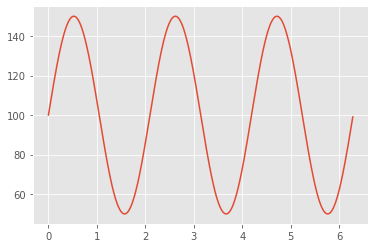

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
y = 50*np.sin(3*x) + 100

plt.plot(x,y)

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

def create_env(config):
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 100

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)

Next, since the environment is registered, we can use the Proximal Policy Optimization (PPO) algorithm from rllib to train our agent.

To check if everything works, set a low episode_reward_mean so a fast check can be done (set at 10). Once everything is working, set it to 3000 and run the training. Once the training is complete, we can get access to the agent’s policy by restoring from the last checkpoint.

In [7]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 500
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "INFO",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-05-11 15:41:23,926	INFO resource_spec.py:223 -- Starting Ray with 2.25 GiB memory available for workers and up to 1.14 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-11 15:41:24,625	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


Trial name,status,loc
PPO_TradingEnv_069b2_00000,RUNNING,


(pid=8861) WARNING:tensorflow:From /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=8861) Instructions for updating:
(pid=8861) non-resource variables are not supported in the long term
(pid=8861) 2021-05-11 15:41:44,189	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f882c316070>}
(pid=8861) 2021-05-11 15:41:44,189	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f882c2ef4c0>}
(pid=8861) 2021-05-11 15:41:44,190	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=8861) 2021-05-11 15:41:44,397	WA

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,1,42.5694,4000,-1.32268


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-42-47
  done: false
  episode_len_mean: 968.5
  episode_reward_max: 211.8616685275353
  episode_reward_mean: 93.00297979541767
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 8
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.0007000000000000001
        entropy: 0.4516399931162596
        entropy_coeff: 0.01
        kl: 0.10699793649837375
        policy_loss: -0.27401565900072455
        total_loss: 0.2204196632374078
        vf_explained_var: 0.0035141240805387497
        vf_loss: 0.9337046798318624
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_uti

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,2,63.4199,8000,93.003


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-43-04
  done: false
  episode_len_mean: 979.0
  episode_reward_max: 452.6180598810442
  episode_reward_mean: 196.74258797997535
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 12
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 0.00030000000000000003
        entropy: 0.2953156102448702
        entropy_coeff: 0.01
        kl: 0.0362004212802276
        policy_loss: -0.1417487955186516
        total_loss: 0.1708114263601601
        vf_explained_var: 0.006287194788455963
        vf_loss: 0.5984463626518846
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_u

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,3,79.8978,12000,196.743


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-43-19
  done: false
  episode_len_mean: 984.25
  episode_reward_max: 514.2845232437483
  episode_reward_mean: 272.58273544634153
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 16
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.800000000000001e-05
        entropy: 0.21171212941408157
        entropy_coeff: 0.01
        kl: 0.010098091064719483
        policy_loss: -0.08910542220110074
        total_loss: 0.10735260212095454
        vf_explained_var: 0.020046614110469818
        vf_loss: 0.38351786881685257
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_perc

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,4,94.4362,16000,272.583


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-43-34
  done: false
  episode_len_mean: 987.4
  episode_reward_max: 555.4319447089742
  episode_reward_mean: 327.51131643711386
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 20
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.400000000000001e-05
        entropy: 0.14943885384127498
        entropy_coeff: 0.01
        kl: 0.0064268714195350185
        policy_loss: -0.06540235719876364
        total_loss: 0.05403180728899315
        vf_explained_var: 0.037968508899211884
        vf_loss: 0.23318082257173955
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_perc

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,5,110.085,20000,327.511


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-43-50
  done: false
  episode_len_mean: 989.5
  episode_reward_max: 577.7611091124411
  episode_reward_mean: 367.4807262149545
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 24
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.0e-05
        entropy: 0.09894834761507809
        entropy_coeff: 0.01
        kl: 0.00540912154247053
        policy_loss: -0.055133912319433875
        total_loss: 0.032264078967273235
        vf_explained_var: 0.04249178618192673
        vf_loss: 0.16947262454777956
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.99999999

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,6,126.133,24000,367.481


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-44-07
  done: false
  episode_len_mean: 991.0
  episode_reward_max: 584.5106221794547
  episode_reward_mean: 397.37926309502757
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 28
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 8.6e-05
        entropy: 0.06149146659299731
        entropy_coeff: 0.01
        kl: 0.004008445088402368
        policy_loss: -0.03621997815207578
        total_loss: 0.025092294585192576
        vf_explained_var: 0.02381841465830803
        vf_loss: 0.11844297288917005
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.1
    r

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,7,142.532,28000,397.379


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-44-21
  done: false
  episode_len_mean: 992.125
  episode_reward_max: 594.5035511511837
  episode_reward_mean: 421.706751894934
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 32
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.2e-05
        entropy: 0.033562801603693515
        entropy_coeff: 0.01
        kl: 0.0037318764807423577
        policy_loss: -0.03224907850380987
        total_loss: -0.0032486749696545303
        vf_explained_var: -0.042969703674316406
        vf_loss: 0.056153054705646355
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 46

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,8,157.177,32000,421.707


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-44-37
  done: false
  episode_len_mean: 993.0
  episode_reward_max: 597.5501787809792
  episode_reward_mean: 441.0607477790545
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 36
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 7.8e-05
        entropy: 0.019997637253254652
        entropy_coeff: 0.01
        kl: 0.0019064769294345751
        policy_loss: -0.025618029525503516
        total_loss: -0.0054633611580356956
        vf_explained_var: -0.10890258848667145
        vf_loss: 0.040065854736894835
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,9,172.333,36000,441.061


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-44-52
  done: false
  episode_len_mean: 993.7
  episode_reward_max: 597.7806929534167
  episode_reward_mean: 456.5599413649103
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 40
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.084375
        cur_lr: 7.400000000000001e-05
        entropy: 0.012722281950118486
        entropy_coeff: 0.01
        kl: 0.0008360847623407608
        policy_loss: -0.018939359666546807
        total_loss: -0.005640060437144712
        vf_explained_var: -0.26837605237960815
        vf_loss: 0.02671195207949495
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_ut

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,10,187.722,40000,456.56


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-45-10
  done: false
  episode_len_mean: 994.2727272727273
  episode_reward_max: 598.0640967569352
  episode_reward_mean: 469.38100677679364
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 44
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0421875
        cur_lr: 7.000000000000001e-05
        entropy: 0.0100483644673659
        entropy_coeff: 0.01
        kl: 0.00041139697782455187
        policy_loss: -0.00970483695709845
        total_loss: 0.0015491239610128105
        vf_explained_var: -0.3073464632034302
        vf_loss: 0.022674179003843165
    num_steps_sampled: 44000
    num_steps_trained: 44000
  iterations_since_restore: 11
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,11,205.642,44000,469.381


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-45-33
  done: false
  episode_len_mean: 994.75
  episode_reward_max: 598.0640967569352
  episode_reward_mean: 480.05454513264976
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 48
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.02109375
        cur_lr: 6.6e-05
        entropy: 0.009048040381458122
        entropy_coeff: 0.01
        kl: 0.00031267100442278206
        policy_loss: -0.011716713066562079
        total_loss: -0.0014103094581514597
        vf_explained_var: -0.4320663511753082
        vf_loss: 0.02078057115068077
    num_steps_sampled: 48000
    num_steps_trained: 48000
  iterations_since_restore: 12
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percen

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,12,228.316,48000,480.055


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-45-47
  done: false
  episode_len_mean: 995.1538461538462
  episode_reward_max: 598.087736087178
  episode_reward_mean: 489.1261248773795
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 52
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.010546875
        cur_lr: 6.2e-05
        entropy: 0.007743861993731116
        entropy_coeff: 0.01
        kl: 0.0001222961149665025
        policy_loss: -0.008496924870996736
        total_loss: -0.0023038871004246175
        vf_explained_var: -0.4617574214935303
        vf_loss: 0.012538369854155462
    num_steps_sampled: 52000
    num_steps_trained: 52000
  iterations_since_restore: 13
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_u

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,13,242.409,52000,489.126


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-46-03
  done: false
  episode_len_mean: 995.5
  episode_reward_max: 598.087736087178
  episode_reward_mean: 496.90614235252593
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 56
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.0052734375
        cur_lr: 5.8e-05
        entropy: 0.007111423014180218
        entropy_coeff: 0.01
        kl: 0.00019080891055267557
        policy_loss: -0.005945414042798802
        total_loss: 0.0006784410797990859
        vf_explained_var: -0.44800543785095215
        vf_loss: 0.013387937324296217
    num_steps_sampled: 56000
    num_steps_trained: 56000
  iterations_since_restore: 14
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_perce

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,14,258.564,56000,496.906


Result for PPO_TradingEnv_069b2_00000:
  custom_metrics: {}
  date: 2021-05-11_15-46-18
  done: true
  episode_len_mean: 995.8
  episode_reward_max: 598.087736087178
  episode_reward_mean: 503.6474945903616
  episode_reward_min: -29.823418229853758
  episodes_this_iter: 4
  episodes_total: 60
  experiment_id: 5b1b9021a9054220a0ff910dcb8c4e5d
  experiment_tag: '0'
  hostname: Yuans-MacBook-Air.local
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00263671875
        cur_lr: 5.4000000000000005e-05
        entropy: 0.006370373274421581
        entropy_coeff: 0.01
        kl: 0.00021891236122328905
        policy_loss: -0.010696840472519398
        total_loss: -0.0036562347086146474
        vf_explained_var: -0.42105916142463684
        vf_loss: 0.014207467057531176
    num_steps_sampled: 60000
    num_steps_trained: 60000
  iterations_since_restore: 15
  node_ip: 192.168.0.249
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
   

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,RUNNING,192.168.0.249:8861,15,273.567,60000,503.647


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_069b2_00000,TERMINATED,,15,273.567,60000,503.647


In [8]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

print(checkpoint_path)

/Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-11_15-41-28m3ikjmjj/checkpoint_15/checkpoint-15


In [9]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "INFO",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-11 15:51:12,995	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fc82159d460>}
2021-05-11 15:51:12,996	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc8215b65e0>}
2021-05-11 15:51:12,997	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-11 15:51:13,206	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2021-05-11 15:51:13,390	INFO trainable.py:472 -- Restored on 192.168.0.249 from checkpoint: /Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-11_15-41-28m3ikjmjj/checkpoint_15/checkpoint-15
2021-05-11 15:51:13,394	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': None, '_time_total': 273.5669734477997, '_episodes_

(pid=8863) /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
(pid=8863)   tensor = torch.from_numpy(np.asarray(item))
(pid=8922) /Users/yuan/Projects/github/ai-trading/env/lib/python3.8/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or ma

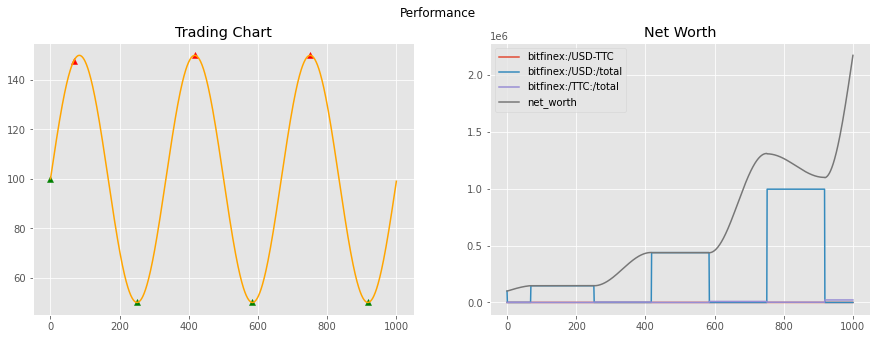

In [10]:
# Instantiate the environment
env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

In [11]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """Creates a symbolic fourier series of order `n`.

    Parameters
    ----------
    x : `symfit.Variable`
        The input variable for the function.
    f : `symfit.Parameter`
        Frequency of the fourier series
    n : int
        Order of the fourier series.
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))

    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series


def gbm(price: float,
        mu: float,
        sigma: float,
        dt: float,
        n: int) -> np.array:
    """Generates a geometric brownian motion path.

    Parameters
    ----------
    price : float
        The initial price of the series.
    mu : float
        The percentage drift.
    sigma : float
        The percentage volatility.
    dt : float
        The time step size.
    n : int
        The number of steps to be generated in the path.

    Returns
    -------
    `np.array`
        The generated path.
    """
    y = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=n).T)
    y = price * y.cumprod(axis=0)
    return y


def fourier_gbm(price, mu, sigma, dt, n, order):

    x, y = variables('x, y')
    w, = parameters('w')
    model_dict = {y: fourier_series(x, f=w, n=order)}

    # Make step function data
    xdata = np.arange(-np.pi, np.pi, 2*np.pi / n)
    ydata = np.log(gbm(price, mu, sigma, dt, n))

    # Define a Fit object for this model and data
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()

    return np.exp(fit.model(x=xdata, **fit_result.params).y)

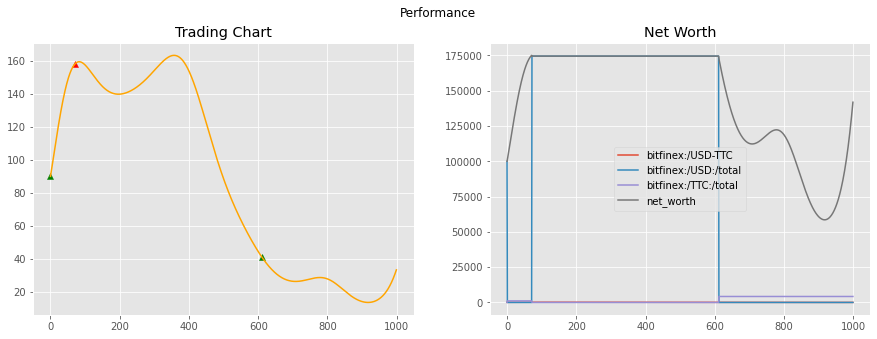

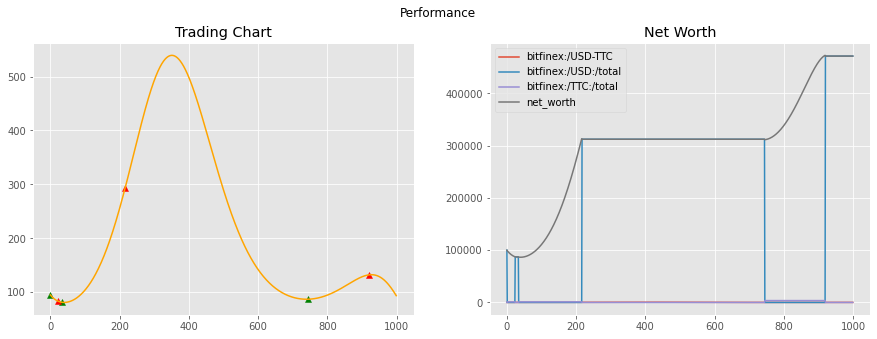

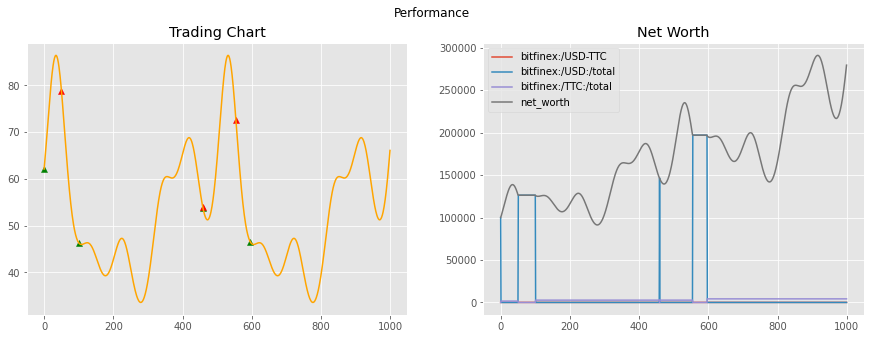

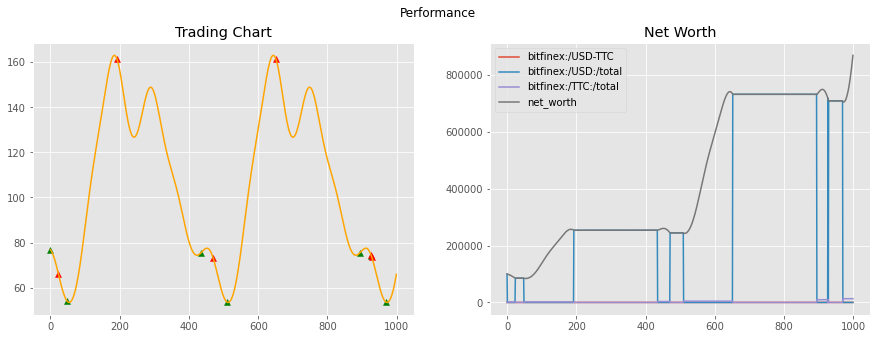

<ipython-input-4-b759ab3da8bd>:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sell = pd.Series(sell)


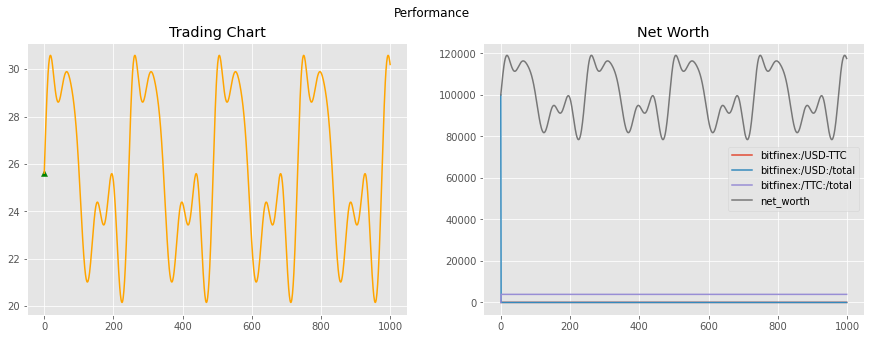

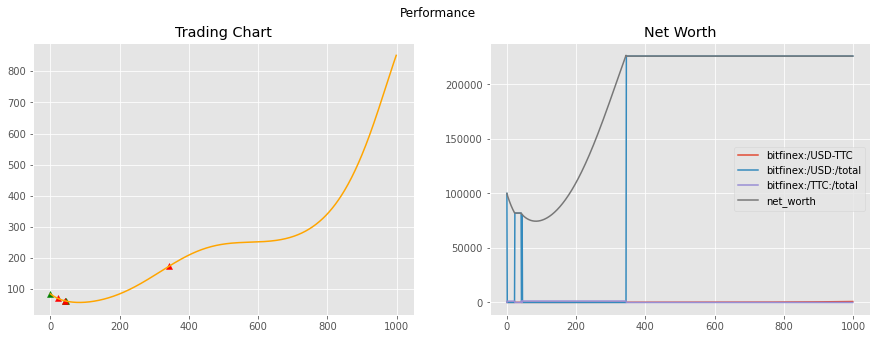

In [12]:
def create_eval_env(config):
    y = config["y"]

    x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
    p = Stream.source(y, dtype="float").rename("USD-TTC")

    bitfinex = Exchange("bitfinex", service=execute_order)(
        p
    )

    cash = Wallet(bitfinex, 100000 * USD)
    asset = Wallet(bitfinex, 0 * TTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(y, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

for _ in range(6):
    # Instantiate the environment
    env = create_eval_env({
        "window_size": 25,
        "y": fourier_gbm(price=100, mu=0.1, sigma=0.5, dt=0.01, n=1000, order=5)
    })


    # Run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()

    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    env.render()

As you can see, the agent has been able to make correct decisions on some of the price curves, but not all of them. In particular, the last three curves showcase some of the shortcomings of the agent. In samples 4 and 5, it doesn’t seem to understand that the general trend is downward, and that it should transfer all of its assets into cash. For sample 6, the agent seemed to stop making decisions altogether. This can most likely be attributed to the high volatility of the price curve, containing many local minima and maxima relative to the first three curves. With the price changing so fast, the agent decides that the best option is to hold the entire time.


### Test trained model with cryptocurrency data

In [13]:
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.oms.instruments import USD, BTC, ETH

def create_env(config, data):
    p = Stream.source(list(data["close"]), dtype="float").rename("USD-BTC")
    bitstamp = Exchange("bitstamp", service=execute_order)(
        p
    )

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0.05 * BTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])


    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(data["close"], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)



,date,unix,open,high,low,close,volume
0,2018-05-15 06:00:00,1526364000,8733.86,8796.68,8707.28,8740.99,559.93
1,2018-05-15 07:00:00,1526367600,8740.99,8766.00,8721.11,8739.00,273.58
2,2018-05-15 08:00:00,1526371200,8739.00,8750.27,8660.53,8728.49,917.79
3,2018-05-15 09:00:00,1526374800,8728.49,8754.40,8701.35,8708.32,182.62
4,2018-05-15 10:00:00,1526378400,8708.32,8865.00,8695.11,8795.90,1260.69


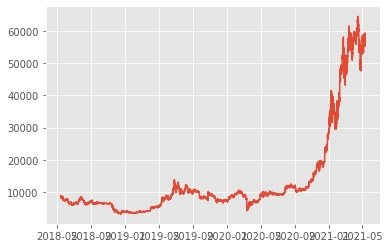

In [14]:
from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.oms.instruments import USD, BTC, ETH

cdd = CryptoDataDownload()

data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")

df = data.copy()

# df.describe()

plt.plot(df['date'], df['close'])

df.head()

{'step': 1, 'net_worth': 10404.680228730002}
{'step': 1001, 'net_worth': 10055.14}
{'step': 2001, 'net_worth': 10055.14}
{'step': 3001, 'net_worth': 10055.14}
{'step': 4001, 'net_worth': 10055.14}
{'step': 5001, 'net_worth': 10055.14}
{'step': 6001, 'net_worth': 10055.14}
{'step': 7001, 'net_worth': 10055.14}
{'step': 8001, 'net_worth': 10055.14}
{'step': 9001, 'net_worth': 10055.14}
{'step': 10001, 'net_worth': 10055.14}
{'step': 11001, 'net_worth': 10055.14}
{'step': 12001, 'net_worth': 10055.14}
{'step': 13001, 'net_worth': 10055.14}
{'step': 14001, 'net_worth': 10055.14}
{'step': 15001, 'net_worth': 10055.14}
{'step': 16001, 'net_worth': 10055.14}
{'step': 17001, 'net_worth': 10055.14}
{'step': 18001, 'net_worth': 10055.14}
{'step': 19001, 'net_worth': 10055.14}
{'step': 20001, 'net_worth': 10055.14}
{'step': 21001, 'net_worth': 10055.14}
{'step': 22001, 'net_worth': 10055.14}
{'step': 23001, 'net_worth': 10055.14}
{'step': 24001, 'net_worth': 10055.14}
{'step': 25001, 'net_worth':

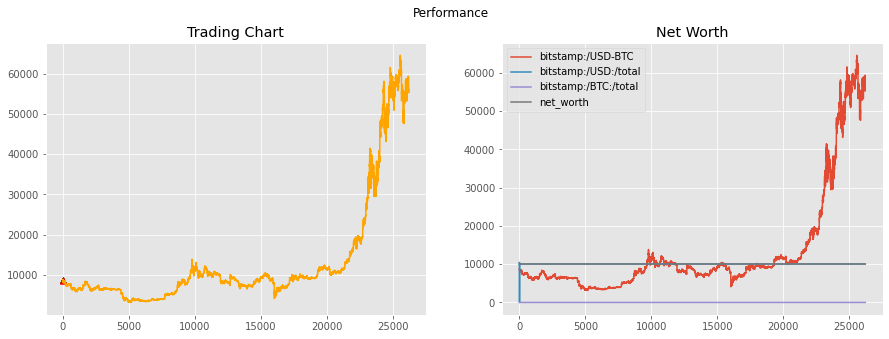

In [15]:
# Instantiate the environment
env = create_env({"window_size": 25}, df)

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    if _ % 1000 == 0: print(info) 

env.render()

In [16]:
from pandasgui import show
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.to_csv('result/BTC_USD_Sample_Model_Performance_{}.csv'.format(today))
gui = show(performance)

In [17]:
ledger = env.action_scheme.portfolio.ledger.as_frame()
gui = show(ledger)

## Conclusion
Our main goal was to test that our reward and action scheme could be used to train an agent to make profitable decisions on a simple sine curve. Despite the suboptimal performance on some of the latter samples, the objective here was to get insight into agent decisions and inform how we engineer future reward schemes. From these basic concepts, you can work up to building more complex action and reward schemes, from which successful algorithms can be made. There is no limit to the kinds of trading environments that can be created with TensorTrade, and I encourage everybody to experiment with the different possibilities. So that about wraps up this tutorial! You can checkout the TensorTrade library to learn more on how to use it to make your own trading environments.